In [372]:
!pip install tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('names.txt', 'r') as file:
    words = file.read().splitlines()

words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [94]:
# build the dataset 

block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []

for w in words:
    # print(w)

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [95]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [288]:
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one
    X, Y = [], []

    for w in words:
        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words=words[:n1])
Xdev, Ydev = build_dataset(words=words[n1:n2])
Xte, Yte = build_dataset(words=words[n2:])

torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [8]:
C = torch.randn((27,2))

In [ ]:
C[X].shape 

torch.Size([32, 3, 2])

In [40]:
emb = C[X] # pytorch indexing is awesome. this line is embeddings the input

emb.shape

torch.Size([32, 3, 2])

In [ ]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # memory heavy as it creates new tensor 

torch.Size([32, 6])

In [54]:
len(torch.unbind(emb, 1))

3

In [55]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [56]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [62]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # here pytorch interprets the -1 as the size. Details: we had 32*3*2, we wentered 6; pytorch divides 32*3*2/6 and puts whatever left inplace of -1

In [58]:
(emb.view(-1, 6) @ W1).shape

torch.Size([32, 100])

In [59]:
b1.shape

torch.Size([100])

In [60]:
# 32, 100       broadcasting rules in pytorch. it aligns on the right that creates a fake dimension...
#  1, 100

In [64]:
h.shape

torch.Size([32, 100])

In [65]:
W2 = torch.randn((100, 27))
b2 = torch. randn(27)

logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [69]:
counts = logits.exp()
prob = counts/counts.sum(1, keepdim=True)

In [74]:
prob.shape

torch.Size([32, 27])

In [76]:
loss = -prob[torch.arange(32), Y].log().mean()

In [77]:
loss

tensor(16.3961)

# Training

In [78]:
# clean and readable code 

In [289]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [392]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [393]:
sum(p.nelement() for p in parameters) # num of parameters in total

17697

In [395]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

In [396]:
losses = []

In [400]:
from tqdm import tqdm

# lri = []
# lossi = []


for i in tqdm(range(200000), desc="training the model"):


    #constructing minibatches
    ix = torch.randint(0, Xtr.shape[0], (64,))


    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    # print(loss.item())

    #backwakrd pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    # lr = lrs[i]
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
    # if i%100==0:
    #     emb = C[X] 
    #     h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
    #     logits = h @ W2 + b2
    #     loss = F.cross_entropy(logits, Y)
    #     losses.append(loss.item())
    losses.append(loss.log10().item())
    if i%10000==0:
        print(loss.item())


# print(loss.item())


training the model:   0%|          | 505/200000 [00:00<01:12, 2745.78it/s]

2.023036241531372


training the model:   5%|▌         | 10419/200000 [00:02<00:49, 3818.67it/s]

1.9955047369003296


training the model:  10%|█         | 20741/200000 [00:05<00:45, 3971.06it/s]

2.177570343017578


training the model:  15%|█▌        | 30418/200000 [00:08<00:43, 3922.50it/s]

2.415067434310913


training the model:  20%|██        | 40611/200000 [00:11<00:46, 3418.74it/s]

2.265411376953125


training the model:  25%|██▌       | 50627/200000 [00:13<00:37, 4032.53it/s]

2.1923725605010986


training the model:  30%|███       | 60832/200000 [00:16<00:34, 4062.87it/s]

2.262681722640991


training the model:  35%|███▌      | 70622/200000 [00:19<00:32, 4010.12it/s]

2.2851309776306152


training the model:  40%|████      | 80764/200000 [00:21<00:29, 4061.90it/s]

2.3026599884033203


training the model:  45%|████▌     | 90561/200000 [00:24<00:30, 3645.31it/s]

2.298356771469116


training the model:  50%|█████     | 100401/200000 [00:27<00:26, 3824.94it/s]

2.2919487953186035


training the model:  55%|█████▌    | 110558/200000 [00:29<00:23, 3805.37it/s]

1.8348509073257446


training the model:  60%|██████    | 120719/200000 [00:32<00:19, 3975.17it/s]

1.9195195436477661


training the model:  65%|██████▌   | 130691/200000 [00:34<00:17, 3973.59it/s]

2.051123857498169


training the model:  70%|███████   | 140725/200000 [00:37<00:14, 4003.21it/s]

2.0982906818389893


training the model:  75%|███████▌  | 150725/200000 [00:40<00:12, 4029.36it/s]

2.0358963012695312


training the model:  80%|████████  | 160752/200000 [00:42<00:09, 4010.86it/s]

2.094341516494751


training the model:  85%|████████▌ | 170713/200000 [00:45<00:07, 3715.62it/s]

2.004779577255249


training the model:  90%|█████████ | 180542/200000 [00:47<00:05, 3673.35it/s]

1.989151120185852


training the model:  95%|█████████▌| 190538/200000 [00:50<00:02, 3639.44it/s]

2.004084587097168


training the model: 100%|██████████| 200000/200000 [00:52<00:00, 3776.51it/s]


In [401]:
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss)

tensor(2.0572, grad_fn=<NllLossBackward0>)


In [402]:
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss)

tensor(2.1380, grad_fn=<NllLossBackward0>)


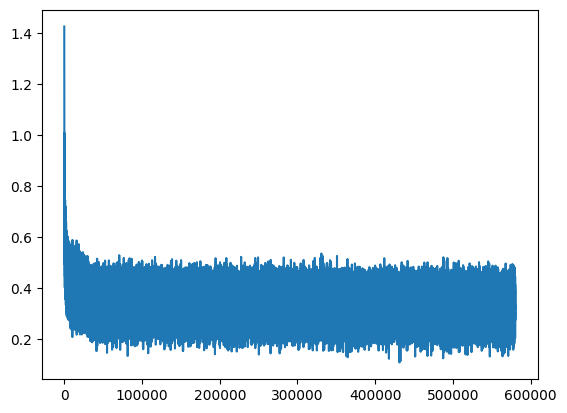

In [378]:
plt.plot(range(len(losses)), losses)

In [112]:
logits.max(1)

torch.return_types.max(
values=tensor([3.0118, 3.4345, 3.4345, 3.9666, 3.4072, 2.8404, 4.1417, 1.6754, 3.4345,
        2.9413, 2.7502, 2.7751, 2.8227, 3.4065, 2.3092, 3.4832, 2.7445, 1.7481,
        2.5941, 3.4345, 3.2779, 3.4345, 3.4969, 2.8404, 2.2532, 2.9893, 3.4345,
        3.4345, 3.4022, 2.0462, 4.1740, 3.1229], grad_fn=<MaxBackward0>),
indices=tensor([14, 18, 18, 18, 14,  1,  1, 18, 18,  9, 14, 18,  0,  1, 18, 18, 14,  5,
         9, 18, 18, 18,  1,  1, 18, 14, 18, 18, 18,  5, 14,  5]))

In [93]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

# Visualizing embeddings

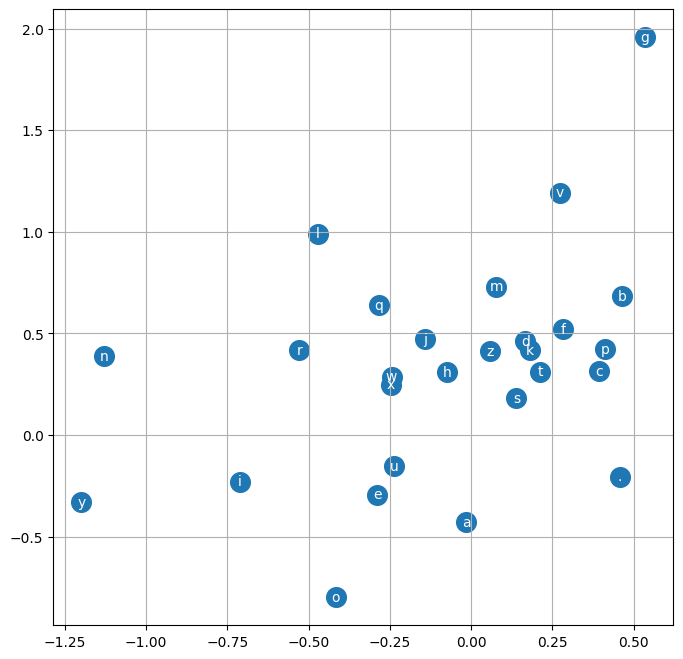

In [335]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

# Sample from the model

In [416]:
g = torch.Generator().manual_seed(42)

for _ in range(20):
    out =[]
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break;

    print(''.join(itos[i] for i in out))

anuelen.
tia.
marian.
dante.
namillaylen.
kemarce.
kan.
epiacenden.
dmin.
kend.
josedrick.
lor.
miquetzabelle.
ine.
camarvi.
karlen.
jaymar.
tal.
jena.
judger.
